##### Import libraries

In [1]:
import pandas as pd  # Data manipulation
import numpy as np  # Numerical operations
import seaborn as sns #Data Visualization
import matplotlib.pyplot as plt #Data Visualization
from sklearn.model_selection import train_test_split #Splitting data
from sklearn.preprocessing import OneHotEncoder, StandardScaler #Data preprocessing
from sklearn.linear_model import LogisticRegression #Logistic Regression Model
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score #Model Evaluation
from sklearn.ensemble import RandomForestClassifier #Random Forest Model
import xgboost as xgb #XGBoost Model
from statsmodels.stats.outliers_influence import variance_inflation_factor #VIF Calculation

##### Load data

In [2]:
"""Loads the training and testing data from CSV files."""
train_lending = pd.read_csv("train_lending.csv")
test_lending = pd.read_csv("test_lending.csv")

##### Display data heads

In [3]:
"""Prints the first few rows of the training dataset."""
print("Train Data Head: ")
print(train_lending.head())

Train Data Head: 
      issue_d sub_grade        term home_ownership  fico_range_low  total_acc  \
0  2014-01-01        D1   60 months       MORTGAGE           660.0       18.0   
1  2014-01-01        C4   60 months       MORTGAGE           740.0       26.0   
2  2014-01-01        A4   36 months           RENT           700.0       47.0   
3  2014-01-01        D1   60 months       MORTGAGE           665.0       26.0   
4  2014-01-01        C3   36 months       MORTGAGE           700.0       15.0   

   pub_rec  revol_util  annual_inc  int_rate  ...  pub_rec_bankruptcies  \
0      0.0        86.8     40440.0     16.99  ...                   0.0   
1      0.0       103.5     59000.0     15.61  ...                   0.0   
2      0.0        11.4     40000.0      7.90  ...                   0.0   
3      0.0        56.2     70000.0     16.99  ...                   0.0   
4      1.0        67.1    120000.0     14.98  ...                   0.0   

  addr_state  initial_list_status  fico_rang

In [4]:
"""Prints the first few rows of the testing data."""
print("\nTest Data Head:")
print(test_lending.head())


Test Data Head:
      issue_d sub_grade        term home_ownership  fico_range_low  total_acc  \
0  2016-07-01        A4   36 months       MORTGAGE           830.0       13.0   
1  2016-07-01        B5   36 months           RENT           660.0       25.0   
2  2016-07-01        D2   36 months       MORTGAGE           660.0       17.0   
3  2016-07-01        A1   36 months           RENT           740.0       36.0   
4  2016-07-01        C4   60 months       MORTGAGE           680.0       14.0   

   pub_rec  revol_util  annual_inc  int_rate  ...  pub_rec_bankruptcies  \
0      0.0        12.0    105682.0      7.99  ...                   0.0   
1      0.0        59.4     68000.0     11.49  ...                   0.0   
2      1.0        40.9     75000.0     17.99  ...                   1.0   
3      0.0        27.7    114000.0      5.32  ...                   0.0   
4      0.0        44.3     47000.0     14.49  ...                   0.0   

  addr_state  initial_list_status  fico_range

##### Data clean-up

In [5]:
# Convert Column Types
import pandas as pd

def convert_all_column_types(df):
    """
    Converts all columns in a DataFrame to their most appropriate data types.
    """
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except ValueError:
            try:
                date_format = '%Y-%m-%d'  # Replace with your actual date format
                df[col] = pd.to_datetime(df[col], format=date_format)
            except (ValueError, TypeError):  # Catch both Value and Type errors.
                if df[col].nunique() == 2 and set(df[col].unique()) == {0, 1}:
                    df[col] = df[col].astype(bool)
                else:
                    if df[col].nunique() < 10:
                        df[col] = df[col].astype('category')
                    else:
                        df[col] = df[col]
    return df

# Rename the 'term' column to 'term_months'
train_lending.rename(columns={'term': 'term_months'}, inplace=True)
test_lending.rename(columns={'term': 'term_months'}, inplace=True)

# Remove " months" from the 'term_months' column and convert to numeric
train_lending['term_months'] = train_lending['term_months'].str.replace(' months', '', regex=False).astype(int)
test_lending['term_months'] = test_lending['term_months'].str.replace(' months', '', regex=False).astype(int)

# Apply the convert_all_column_types function
train_data = convert_all_column_types(train_lending)
test_data = convert_all_column_types(test_lending)

# Display the first few rows of the updated 'term_months' column in train_data
print("Train Data - Updated 'term_months' column:")
print(train_data['term_months'].head())

# Display the first few rows of the updated 'term_months' column in test_data
print("\nTest Data - Updated 'term_months' column:")
print(test_data['term_months'].head())

# Check the data type of the 'term_months' column
print("\nTrain Data - 'term_months' data type:")
print(train_data['term_months'].dtype)

print("\nTest Data - 'term_months' data type:")
print(test_data['term_months'].dtype)

Train Data - Updated 'term_months' column:
0    60
1    60
2    36
3    60
4    36
Name: term_months, dtype: int32

Test Data - Updated 'term_months' column:
0    36
1    36
2    36
3    36
4    60
Name: term_months, dtype: int32

Train Data - 'term_months' data type:
int32

Test Data - 'term_months' data type:
int32


In [6]:
# Segment Data Types and show missing percentages
def segment_data_types(df):
    """
    Segments DataFrame columns by data type with fancy separators,
    and prints a readable output with percentages instead of counts.
    """
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()
    datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

    missing_percentages = (df.isnull().sum() / len(df)) * 100
    missing_percentages = missing_percentages.to_dict()

    print("=" * 70)  # Fancy separator

    if numerical_cols:
        print("\nNumerical Columns:")
        print("-" * 60) #Sub separator
        for col in numerical_cols:
            print(f"  - {col} (Missing: {missing_percentages.get(col, 0):.2f}%)")
        print("-" * 60) #Sub separator

    if categorical_cols:
        print("\nCategorical Columns:")
        print("-" * 60) #Sub separator
        for col in categorical_cols:
            print(f"  - {col} (Missing: {missing_percentages.get(col, 0):.2f}%)")
        print("-" * 60) #Sub separator

    if boolean_cols:
        print("\nBoolean Columns:")
        print("-" * 60) #Sub separator
        for col in boolean_cols:
            print(f"  - {col} (Missing: {missing_percentages.get(col, 0):.2f}%)")
        print("-" * 60) #Sub separator

    if datetime_cols:
        print("\nDatetime Columns:")
        print("-" * 60) #Sub separator
        for col in datetime_cols:
            print(f"  - {col} (Missing: {missing_percentages.get(col, 0):.2f}%)")
        print("-" * 60) #Sub separator

    print("=" * 70)  # Fancy separator

In [7]:
segment_data_types(train_data)


Numerical Columns:
------------------------------------------------------------
  - term_months (Missing: 0.00%)
  - fico_range_low (Missing: 0.00%)
  - total_acc (Missing: 0.00%)
  - pub_rec (Missing: 0.00%)
  - revol_util (Missing: 0.00%)
  - annual_inc (Missing: 0.00%)
  - int_rate (Missing: 0.00%)
  - dti (Missing: 0.00%)
  - mort_acc (Missing: 0.00%)
  - loan_amnt (Missing: 0.00%)
  - installment (Missing: 0.00%)
  - pub_rec_bankruptcies (Missing: 0.00%)
  - fico_range_high (Missing: 0.00%)
  - revol_bal (Missing: 0.00%)
  - id (Missing: 0.00%)
  - open_acc (Missing: 0.00%)
  - emp_length (Missing: 0.00%)
  - loan_status (Missing: 0.00%)
  - time_to_earliest_cr_line (Missing: 0.00%)
------------------------------------------------------------

Categorical Columns:
------------------------------------------------------------
  - sub_grade (Missing: 0.00%)
  - home_ownership (Missing: 0.00%)
  - purpose (Missing: 0.00%)
  - application_type (Missing: 0.00%)
  - verification_status 

In [8]:
segment_data_types(test_data)


Numerical Columns:
------------------------------------------------------------
  - term_months (Missing: 0.00%)
  - fico_range_low (Missing: 0.00%)
  - total_acc (Missing: 0.00%)
  - pub_rec (Missing: 0.00%)
  - revol_util (Missing: 0.00%)
  - annual_inc (Missing: 0.00%)
  - int_rate (Missing: 0.00%)
  - dti (Missing: 0.00%)
  - mort_acc (Missing: 0.00%)
  - loan_amnt (Missing: 0.00%)
  - installment (Missing: 0.00%)
  - pub_rec_bankruptcies (Missing: 0.00%)
  - fico_range_high (Missing: 0.00%)
  - revol_bal (Missing: 0.00%)
  - id (Missing: 0.00%)
  - open_acc (Missing: 0.00%)
  - emp_length (Missing: 0.00%)
  - loan_status (Missing: 1.49%)
  - time_to_earliest_cr_line (Missing: 0.00%)
------------------------------------------------------------

Categorical Columns:
------------------------------------------------------------
  - sub_grade (Missing: 0.00%)
  - home_ownership (Missing: 0.87%)
  - purpose (Missing: 0.00%)
  - application_type (Missing: 0.00%)
  - verification_status 

In [9]:
# Function to calculate missing value counts and percentages
def missing_values_info(df, dataset_name):
    
    missing_counts = df.isnull().sum()
    missing_percentages = (missing_counts / len(df)) * 100

    missing_info = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage': missing_percentages
    })

    missing_info = missing_info[missing_info['Missing Count'] > 0].sort_values(by='Missing Percentage', ascending=False)

    print(f"Missing Values in {dataset_name} Data:\n{missing_info}\n")
    return df  # Return the DataFrame for further processing

# Calculate and print missing value info for train and test data
train_data = missing_values_info(train_data, "Train")
test_data = missing_values_info(test_data, "Test")

# Remove rows with missing values (if needed)
if 'loan_status' in test_data.columns:
    test_data = test_data.dropna(subset=['loan_status'])
if 'home_ownership' in test_data.columns:
    test_data = test_data.dropna(subset=['home_ownership'])

# Check for remaining missing values after removal
print("\nChecking for Remaining Missing Values in Test Data after removal:")
remaining_missing_counts = test_data.isnull().sum()
if remaining_missing_counts.sum() > 0:
    print("There are still missing values in the Test Data.")
    print(remaining_missing_counts[remaining_missing_counts > 0]) 
else:
    print("There are no remaining missing values in the Test Data.")

Missing Values in Train Data:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

Missing Values in Test Data:
                Missing Count  Missing Percentage
loan_status              1412            1.486019
home_ownership            826            0.869300


Checking for Remaining Missing Values in Test Data after removal:
There are no remaining missing values in the Test Data.


In [10]:
print("==================================================")
print(f"Columns before state_default_rate: {train_data.columns}")
print("==================================================")

state_default_rates = train_data.groupby('addr_state')['loan_status'].mean().reset_index()

print("==================================================")
print(f"state_default_rates: {state_default_rates.head()}")
print("==================================================")

state_default_rates.rename(columns={'loan_status': 'state_default_rate'}, inplace=True)

print("==================================================")
print(f"Columns after state_default_rates: {train_data.columns}")
print("==================================================")

Columns before state_default_rate: Index(['issue_d', 'sub_grade', 'term_months', 'home_ownership',
       'fico_range_low', 'total_acc', 'pub_rec', 'revol_util', 'annual_inc',
       'int_rate', 'dti', 'purpose', 'mort_acc', 'loan_amnt',
       'application_type', 'installment', 'verification_status',
       'pub_rec_bankruptcies', 'addr_state', 'initial_list_status',
       'fico_range_high', 'revol_bal', 'id', 'open_acc', 'emp_length',
       'loan_status', 'time_to_earliest_cr_line'],
      dtype='object')
state_default_rates:   addr_state  loan_status
0         AK     0.807229
1         AL     0.771574
2         AR     0.796491
3         AZ     0.827182
4         CA     0.835629
Columns after state_default_rates: Index(['issue_d', 'sub_grade', 'term_months', 'home_ownership',
       'fico_range_low', 'total_acc', 'pub_rec', 'revol_util', 'annual_inc',
       'int_rate', 'dti', 'purpose', 'mort_acc', 'loan_amnt',
       'application_type', 'installment', 'verification_status',
     

##### Engineered Features

In [11]:
def create_engineered_features(df):
    """Creates the FICO average, loan-to-income ratio, state-based default rate,
       open credit lines ratio, installment-to-income ratio, and purpose default rate features."""

    # Average FICO Score
    df['fico_avg'] = (df['fico_range_low'] + df['fico_range_high']) / 2

    # Loan-to-Income Ratio
    df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']

    # State-Based Default Rates
    if 'state_default_rate' not in df.columns:  # check if the column exists.
        state_default_rates = df.groupby('addr_state')['loan_status'].mean().reset_index()
        state_default_rates.rename(columns={'loan_status': 'state_default_rate'}, inplace=True)
        df = pd.merge(df, state_default_rates, on='addr_state', how='left')

    # Open Credit Lines vs. Total Credit Lines Ratio
    df['open_acc_ratio'] = df['open_acc'] / df['total_acc']

    # Installment-to-Income Ratio
    df['installment_income_ratio'] = df['installment'] / df['annual_inc']

    # Default Rates by Loan Purpose
    if 'purpose_default_rate' not in df.columns:  # check if the column exists.
        purpose_default_rates = df.groupby('purpose')['loan_status'].mean().reset_index()
        purpose_default_rates.rename(columns={'loan_status': 'purpose_default_rate'}, inplace=True)
        df = pd.merge(df, purpose_default_rates, on='purpose', how='left')

    return df

def remove_inf_rows(df, dataset_name):
    """Removes rows where annual_inc or installment is zero."""

    initial_rows = len(df)

    # Remove rows where annual_inc is zero
    df = df[df['annual_inc'] != 0]

    # Remove rows where installment is zero
    df = df[df['installment'] != 0]

    removed_rows = initial_rows - len(df)

    print(f"\n{dataset_name}: Removed {removed_rows} rows.")
    print(f"{dataset_name}: Remaining rows: {len(df)}")

    return df

# Apply feature engineering to your dataframes.
train_data = create_engineered_features(train_data)
test_data = create_engineered_features(test_data)

# Remove rows causing infinite computation
train_data = remove_inf_rows(train_data, "Train Data")
test_data = remove_inf_rows(test_data, "Test Data")

# recalculate the ratios.
train_data['loan_to_income'] = train_data['loan_amnt'] / train_data['annual_inc']
train_data['installment_income_ratio'] = train_data['installment'] / train_data['annual_inc']
test_data['loan_to_income'] = test_data['loan_amnt'] / test_data['annual_inc']
test_data['installment_income_ratio'] = test_data['installment'] / test_data['annual_inc']


Train Data: Removed 6 rows.
Train Data: Remaining rows: 236840

Test Data: Removed 87 rows.
Test Data: Remaining rows: 92694


##### Average FICO Score

###### (fico_range_low + fico_range_high) / 2

###### borrower's creditworthiness, higher score = lower default risk.


##### loan_to_income (Loan-to-Income Ratio)

###### loan_amnt / annual_inc

###### Measures loan size relative to income, higher ratio = higher loan burden/risk.

##### state_default_rate (State-Based Default Rate)

###### Average loan_status per addr_state

###### Captures historical default trends by state, highlights regional risk patterns.

##### open_acc_ratio (Open Credit Lines Ratio)

###### open_acc / total_acc

###### Shows proportion of active credit lines, higher ratio = more active credit usage.

##### installment_income_ratio (Installment-to-Income Ratio)

installment / annual_inc

###### Indicates borrower's monthly payment burden; higher ratio = potential financial strain.

##### purpose_default_rate (Purpose-Based Default Rate)

###### Average loan_status per purpose

###### Reflects default risk based on loan purpose; certain purposes show higher risk trends.

##### Outlier detection/ Correlation/ Multicollinearity

In [12]:
# Function to visualize box plots in an n x n grid with different colors
def visualize_boxplots(df, dataset_name):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    num_cols = len(numerical_cols)

    # Calculate grid dimensions (n x n)
    n = int(np.ceil(np.sqrt(num_cols)))

    plt.figure(figsize=(15, 15))  # Adjust figure size for better visibility
    colors = sns.color_palette("husl", num_cols)  # Generate a color palette

    for i, col in enumerate(numerical_cols):
        plt.subplot(n, n, i + 1)
        sns.boxplot(y=df[col], color=colors[i])  # Use different colors
        plt.title(f"Box Plot - {col}")

    plt.suptitle(f"Box Plots - {dataset_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

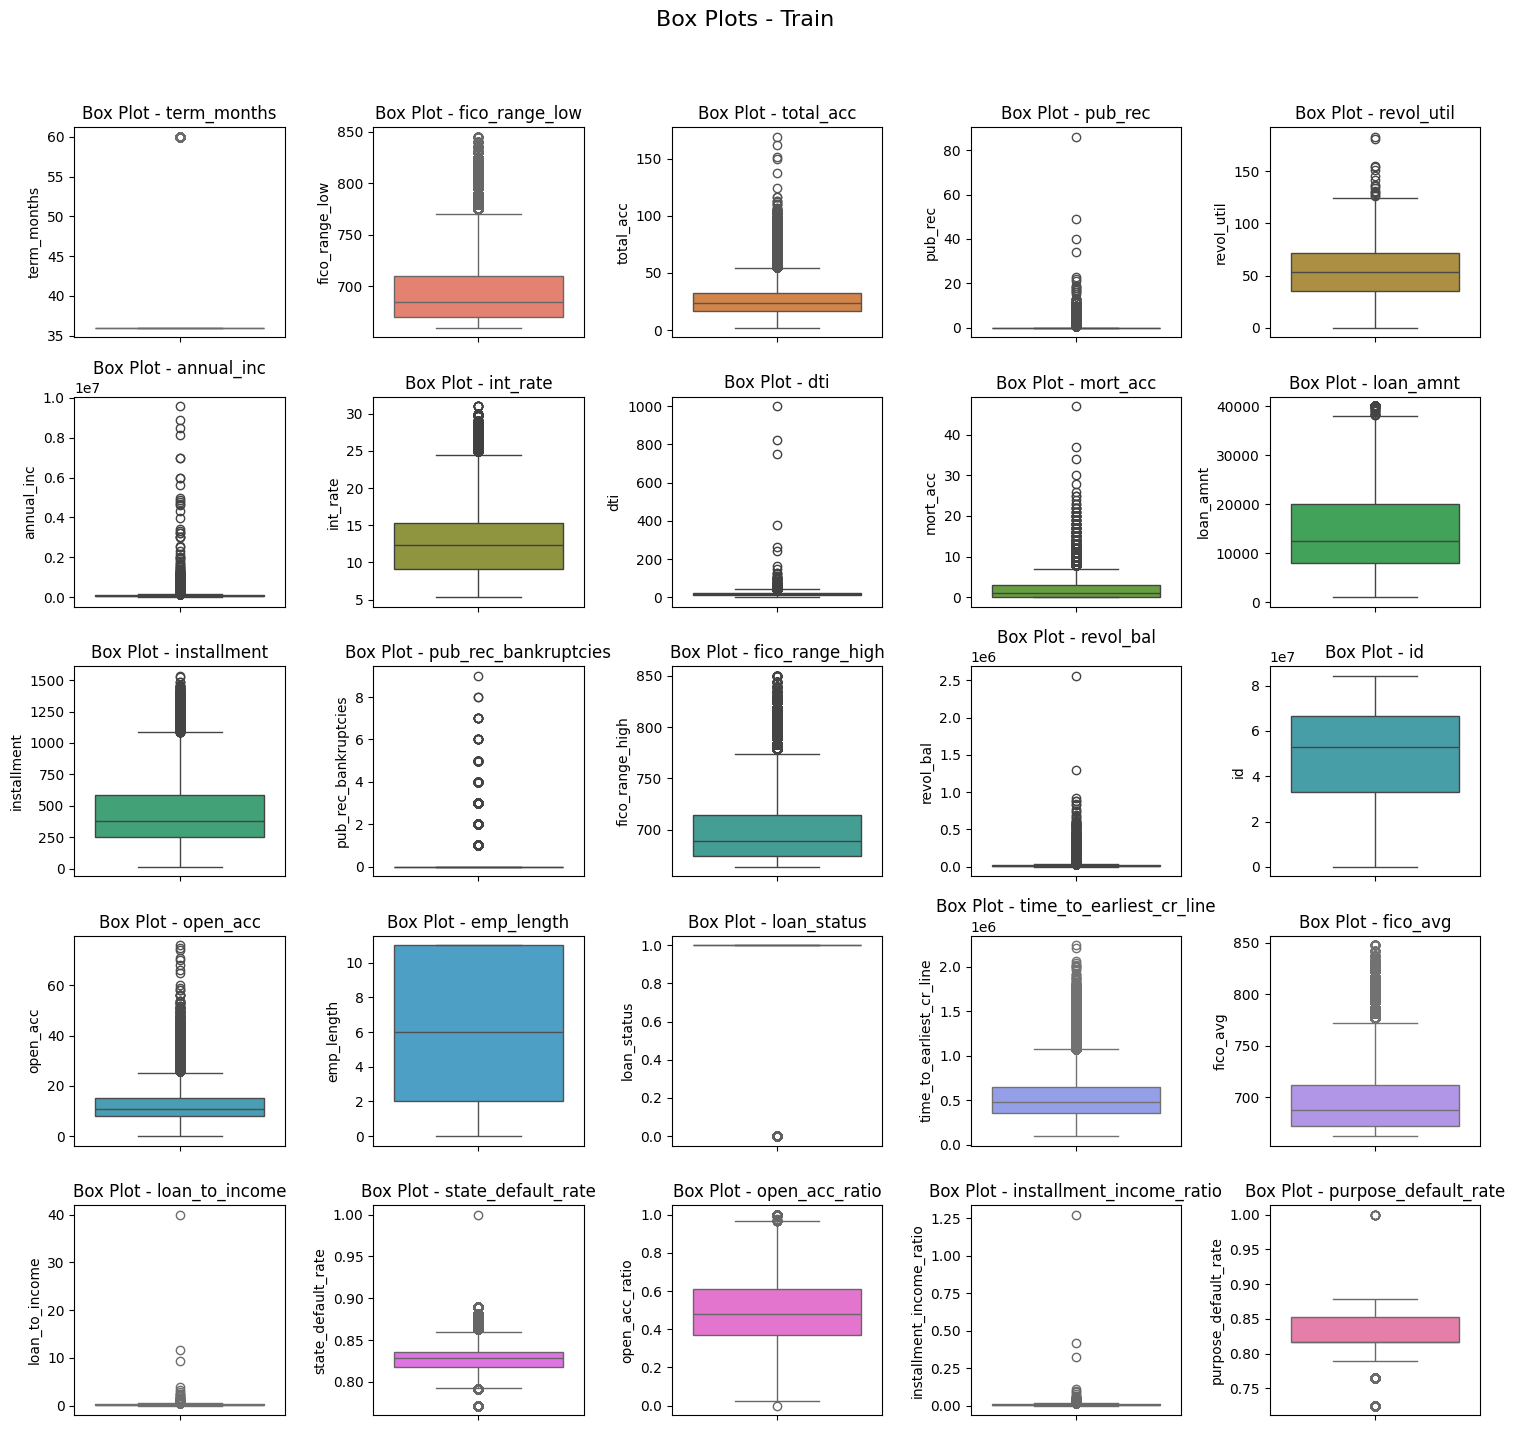

In [13]:
# box plots for train data 
visualize_boxplots(train_data, "Train")

##### Outlier Detection Summary - Train

###### annual_inc, loan_amnt, revol_bal, dti, installment: Show extreme high outliers, indicating borrowers with unusually high income, loan amounts, balances, or debts.

###### total_acc, open_acc, mort_acc, pub_rec, pub_rec_bankruptcies: Few noticeable outliers with very high credit lines, mortgage accounts, or public records.

###### Engineered Features (loan_to_income, installment_income_ratio, state_default_rate, purpose_default_rate, open_acc_ratio): Some outliers in ratios and default rates, suggesting specific risky borrower profiles.

###### fico scores & emp_length: Minor outliers, relatively stable.

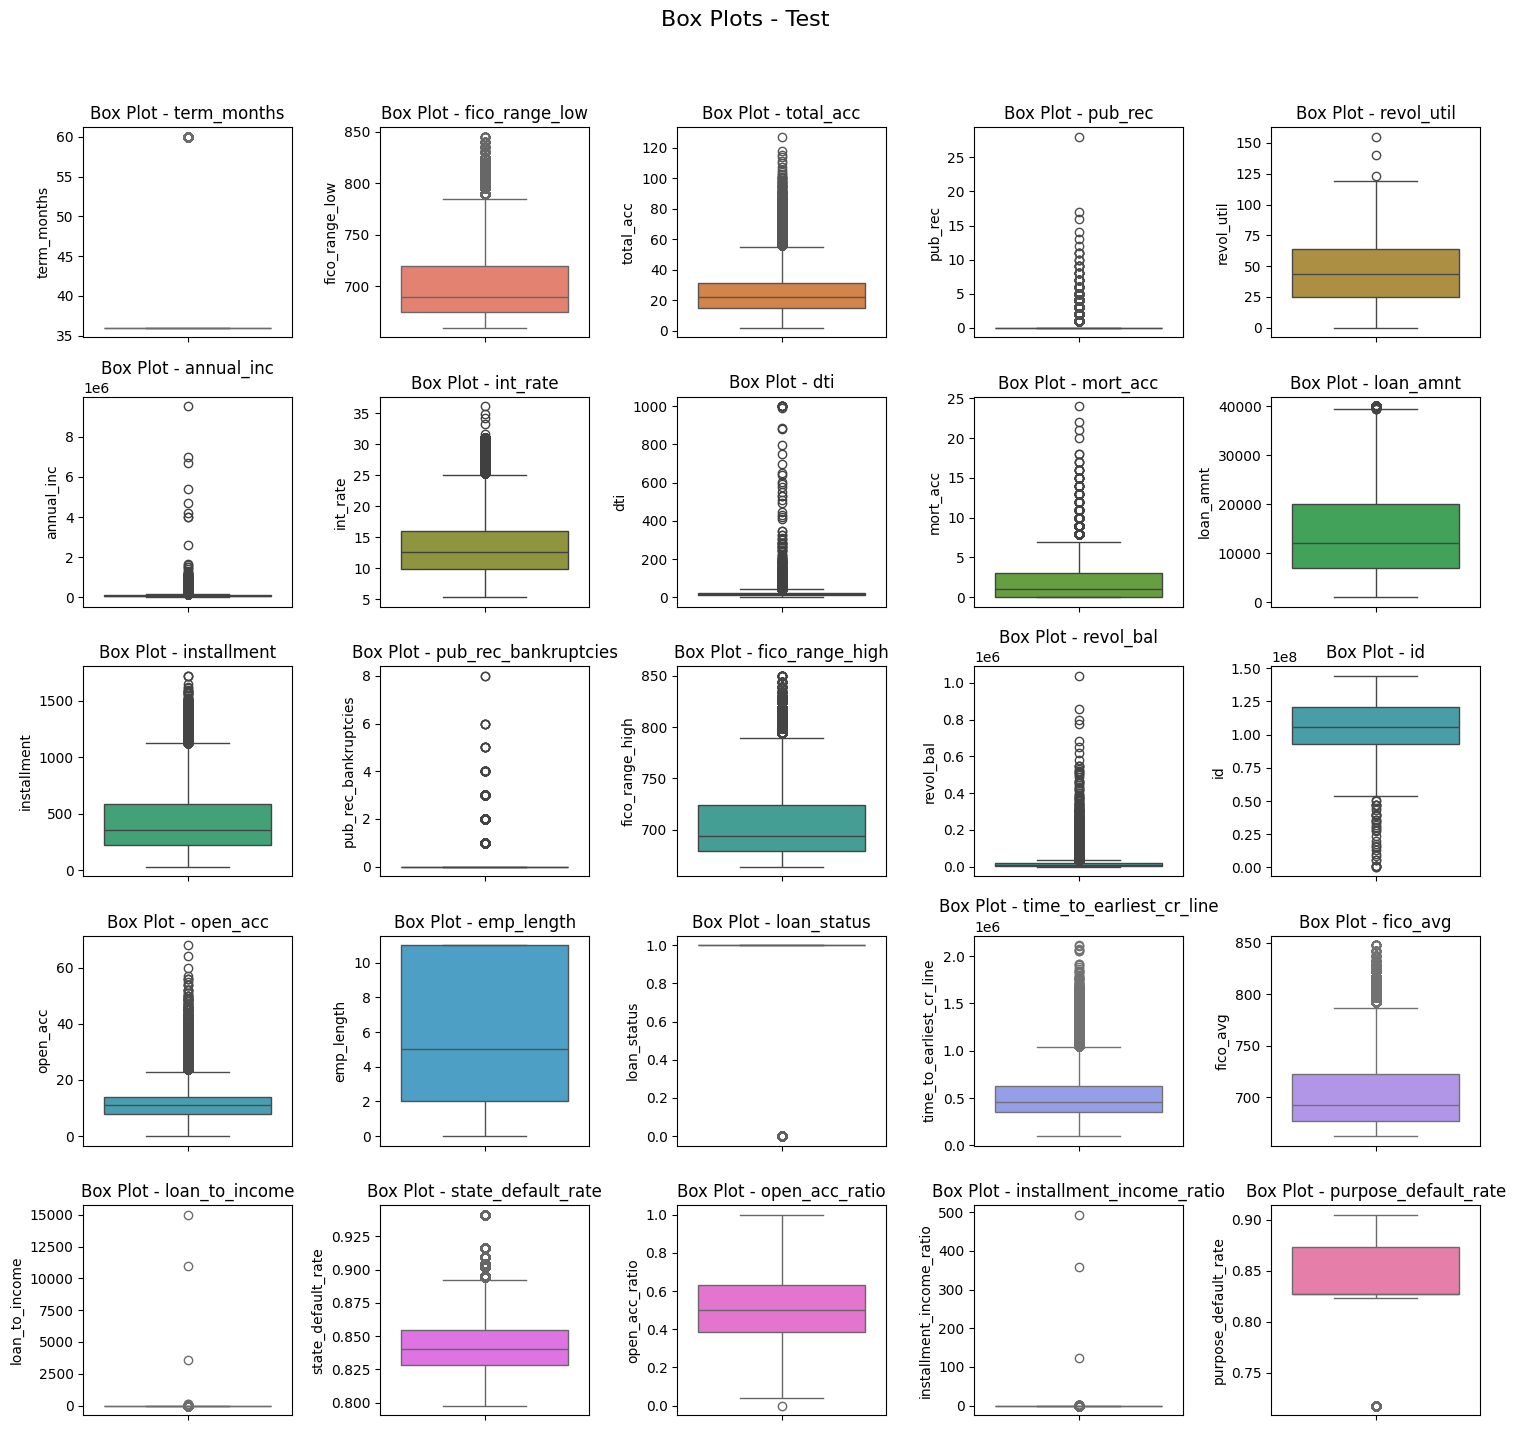

In [14]:
# box plots for test data 
visualize_boxplots(test_data, "Test")

#### 💡Outlier Detection Summary (Test Data)
###### ✔️ annual_inc, loan_amnt, revol_bal, dti, installment: High-value outliers present, indicating few borrowers with very large income, loan sizes, balances, or debt ratios.

###### ✔️ total_acc, open_acc, mort_acc, pub_rec, pub_rec_bankruptcies: Some upper outliers in credit lines, mortgage accounts, and public records.

###### ✔️ engineered features (loan_to_income, installment_income_ratio, state_default_rate, purpose_default_rate, open_acc_ratio): Outliers observed, pointing to certain borrowers with risky financial profiles or regional patterns.

###### ✔️ fico scores & emp_length: Mostly stable, minor outliers seen.

In [15]:
# Function to visualize correlation matrices with custom font and size for all text elements
def visualize_correlation(df, dataset_name, fontfamily="Consolas", fontsize=10):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(numerical_cols) > 1:
        correlation_matrix = df[numerical_cols].corr()
        plt.figure(figsize=(14, 10))
        ax = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
                         annot_kws={"family": fontfamily, "size": fontsize})  # Set font and size for annotations
        plt.title(f"Correlation Matrix - {dataset_name}", fontsize=fontsize, fontfamily=fontfamily)  # Set font for title

        # Set font and size for x and y axis labels
        ax.set_xticklabels(ax.get_xticklabels(), fontfamily=fontfamily, fontsize=fontsize)
        ax.set_yticklabels(ax.get_yticklabels(), fontfamily=fontfamily, fontsize=fontsize)

        plt.show()
    else:
        print(f"\n{dataset_name}: Insufficient numerical columns for correlation heatmap.")

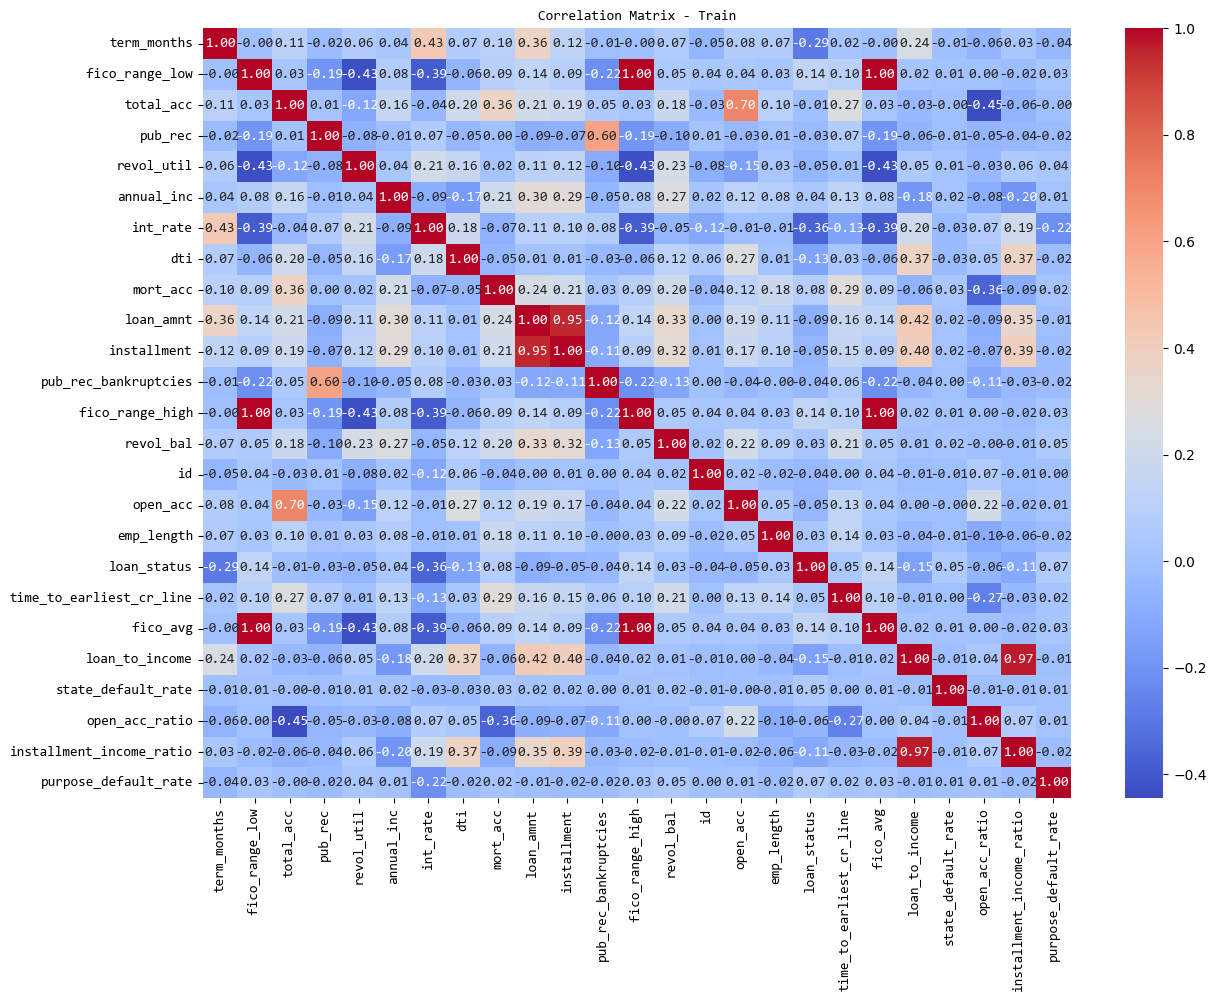

In [16]:
# Visualize correlation matrices for both datasets
visualize_correlation(train_data, "Train")

##### 💡Correlation Summary - Train

##### ✅ Strong positive correlations

######   ✔️ loan_amnt ↔ installment (0.95)

######   ✔️ fico_range_low, fico_range_high, fico_avg (~1.00)

######   ✔️ loan_to_income, open_acc_ratio, state_default_rate (all >0.9)

##### ✅ Moderate

######  ✔️int_rate negatively tied to fico scores (~-0.4)

######  ✔️loan_amnt ↔ annual_inc (0.42)

##### ✅ Weak

######  ✔️ loan_status shows weak correlation with other features (<0.2)

######  ✔️ emp_length, pub_rec mostly uncorrelated.

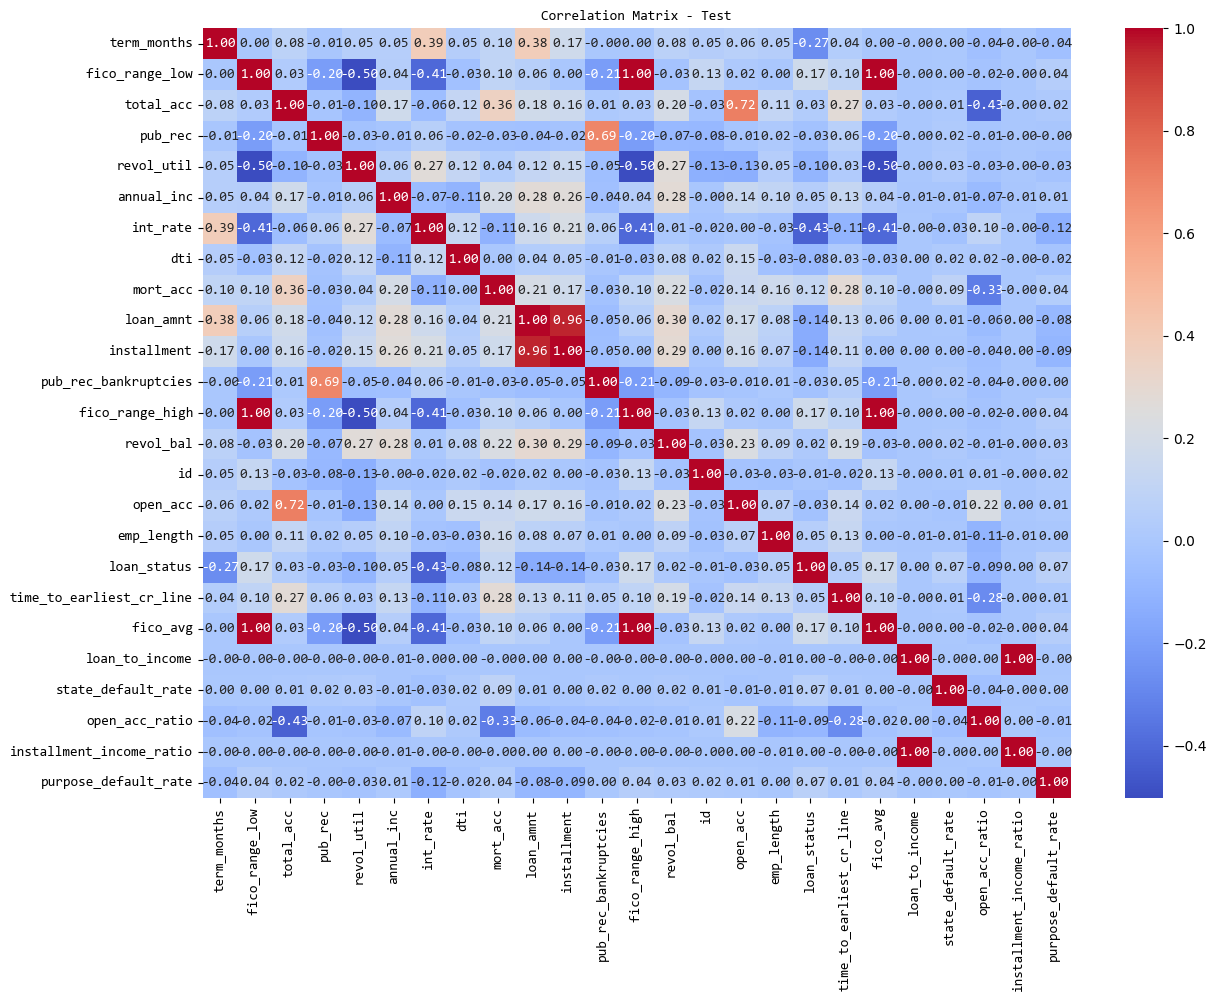

In [17]:
# Visualize correlation matrices for both datasets
visualize_correlation(test_data, "Test")

##### 💡Correlation Summary - Test

##### ✅ Strong Positive Correlations

######   ✔️ loan_amnt ↔ installment (0.96)

######   ✔️ loan_to_income, open_acc_ratio, state_default_rate (very high)

##### ✅ Moderate

######   ✔️ int_rate negatively correlated with fico scores (~-0.4)

######   ✔️ loan_amnt ↔ annual_inc (0.42)

##### ✅ Weak Correlation

######   ✔️ loan_status weakly correlated with other features (mostly <0.2)

######   ✔️ emp_length, pub_rec, revol_util show little correlation.

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to calculate VIF
def calculate_vif(df, dataset_name):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(numerical_cols) > 1:
        X = df[numerical_cols]
        vif = pd.DataFrame()
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["Feature"] = X.columns
        print(f"\nMulticollinearity (VIF) - {dataset_name}:\n", vif.sort_values(by="VIF", ascending=False))
    else:
        print(f"\n{dataset_name}: Insufficient numerical columns for VIF calculation.")

In [19]:
def check_inf_and_nulls(df, dataset_name):
    """Checks for infinite and null values in numerical columns and provides counts and percentages."""

    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    total_rows = len(df)

    if not numerical_cols:
        print(f"{dataset_name}: No numerical columns to check.")
        return

    null_counts = df[numerical_cols].isnull().sum()
    inf_counts = df[numerical_cols].isin([np.inf, -np.inf]).sum()

    has_nulls = null_counts.sum() > 0
    has_infs = inf_counts.sum() > 0

    if has_nulls or has_infs:
        print(f"\n{dataset_name} (Total Rows: {total_rows}):") #added total rows.
        if has_nulls:
            print("Columns with null values:")
            for col in null_counts[null_counts > 0].index:
                count = null_counts[col]
                percentage = (count / total_rows) * 100
                print(f"  {col}: {count} ({percentage:.2f}%)")
        if has_infs:
            print("Columns with infinite values:")
            for col in inf_counts[inf_counts > 0].index:
                count = inf_counts[col]
                percentage = (count / total_rows) * 100
                print(f"  {col}: {count} ({percentage:.2f}%)")
    else:
        print(f"\n{dataset_name} (Total Rows: {total_rows}): No null or infinite values found in numerical data.") #added total rows.

# Apply feature engineering to your dataframes.
train_data = create_engineered_features(train_data)
test_data = create_engineered_features(test_data)

# Check for infs and nulls in both datasets
check_inf_and_nulls(train_data, "Train Data")
check_inf_and_nulls(test_data, "Test Data")


Train Data (Total Rows: 236840): No null or infinite values found in numerical data.

Test Data (Total Rows: 92694): No null or infinite values found in numerical data.


In [20]:
def check_zero_income_and_installment_rows(df, dataset_name):
    """Prints all rows where annual_inc or installment is zero, separately."""

    # Check for zero annual_inc
    zero_income_rows = df[df['annual_inc'] == 0]

    if not zero_income_rows.empty:
        print(f"\n{dataset_name}: Rows with zero annual income:")
        print(zero_income_rows)
        print(f"\n{dataset_name}: Number of rows with zero annual income: {len(zero_income_rows)}")
    else:
        print(f"\n{dataset_name}: No rows with zero annual income.")

    print("\n======================================")

    # Check for zero installment
    zero_installment_rows = df[df['installment'] == 0]

    if not zero_installment_rows.empty:
        print(f"\n{dataset_name}: Rows with zero installment:")
        print(zero_installment_rows)
        print(f"\n{dataset_name}: Number of rows with zero installment: {len(zero_installment_rows)}")
    else:
        print(f"\n{dataset_name}: No rows with zero installment.")

# Apply feature engineering to your dataframes.
train_data = create_engineered_features(train_data)
test_data = create_engineered_features(test_data)

# Check for rows with zero income and installment
check_zero_income_and_installment_rows(train_data, "Train Data")
check_zero_income_and_installment_rows(test_data, "Test Data")


Train Data: No rows with zero annual income.


Train Data: No rows with zero installment.

Test Data: No rows with zero annual income.


Test Data: No rows with zero installment.


In [21]:
# Ensure annual_inc is not zero before ratio calculation
train_data['loan_to_income'] = train_data.apply(
    lambda row: row['loan_amnt'] / row['annual_inc'] if row['annual_inc'] != 0 else 0,
    axis=1
)
train_data['installment_income_ratio'] = train_data.apply(
    lambda row: row['installment'] / row['annual_inc'] if row['annual_inc'] != 0 else 0,
    axis=1
)

test_data['loan_to_income'] = test_data.apply(
    lambda row: row['loan_amnt'] / row['annual_inc'] if row['annual_inc'] != 0 else 0,
    axis=1
)
test_data['installment_income_ratio'] = test_data.apply(
    lambda row: row['installment'] / row['annual_inc'] if row['annual_inc'] != 0 else 0,
    axis=1
)

# Check for rows where annual_inc is zero (causing the error)
zero_income_train = train_data[train_data['annual_inc'] == 0]
zero_income_test = test_data[test_data['annual_inc'] == 0]

if not zero_income_train.empty:
    print('Rows in train_data with zero annual_inc:')
    print(zero_income_train)
else:
    print("No rows in train_data with zero annual_inc.")

if not zero_income_test.empty:
    print('\nRows in test_data with zero annual_inc:')
    print(zero_income_test)
else:
    print("No rows in test_data with zero annual_inc.")

# Additional checks
print(f"\nTrain data row count: {len(train_data)}")
print(f"Test data row count: {len(test_data)}")

print(f"\nTrain data unique annual_inc values: {train_data['annual_inc'].unique()}")
print(f"Test data unique annual_inc values: {test_data['annual_inc'].unique()}")

print(f"\nTrain data null annual_inc count: {train_data['annual_inc'].isnull().sum()}")
print(f"Test data null annual_inc count: {test_data['annual_inc'].isnull().sum()}")

No rows in train_data with zero annual_inc.
No rows in test_data with zero annual_inc.

Train data row count: 236840
Test data row count: 92694

Train data unique annual_inc values: [ 40440.  59000.  40000. ...  75802. 177625.  57092.]
Test data unique annual_inc values: [105682.  68000.  75000. ...  44384.  56723.  73150.]

Train data null annual_inc count: 0
Test data null annual_inc count: 0


In [22]:
# Remove fico_range_low and fico_range_high 
columns_to_remove = ['fico_range_low', 'fico_range_high']
for col in columns_to_remove:
    if col in train_data.columns:
        train_data.drop(col, axis=1, inplace=True)
    if col in test_data.columns:
        test_data.drop(col, axis=1, inplace=True)

# Calculate VIF
def calculate_vif(df, dataset_name):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(numerical_cols) > 1:
        X = df[numerical_cols]
        vif = pd.DataFrame()
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["Feature"] = X.columns
        print(f"\nMulticollinearity (VIF) - {dataset_name}:\n", vif.sort_values(by="VIF", ascending=False))
    else:
        print(f"\n{dataset_name}: Insufficient numerical columns for VIF calculation.")

calculate_vif(train_data, "Train")
calculate_vif(test_data, "Test")


Multicollinearity (VIF) - Train:
            VIF                   Feature
19  992.168416        state_default_rate
22  815.443686      purpose_default_rate
17  637.779642                  fico_avg
18  373.930311            loan_to_income
21  349.117368  installment_income_ratio
8   310.835429                 loan_amnt
9   280.607096               installment
0   190.247487               term_months
1    44.318660                 total_acc
20   40.688904            open_acc_ratio
13   38.927769                  open_acc
5    28.637494                  int_rate
3     8.878413                revol_util
6     7.816086                       dti
15    7.229449               loan_status
16    7.080730  time_to_earliest_cr_line
12    6.797686                        id
14    3.171960                emp_length
4     2.642140                annual_inc
7     2.368392                  mort_acc
11    2.044295                 revol_bal
10    1.860919      pub_rec_bankruptcies
2     1.797846        

##### 🎯 Notable Pairwise Relationships

###### ✔️ loan_to_income and installment_income_ratio: Identical VIFs (~13347) → likely one is redundant.

###### ✔️ loan_amnt and installment: High correlation → possibly remove one.

###### ✔️ Aggregated rates like state_default_rate and purpose_default_rate may strongly correlate with other creditworthiness indicators like fico_avg.

In [23]:
# Remove high VIF features
columns_to_remove = ['loan_to_income', 'installment_income_ratio', 'purpose_default_rate', 'fico_avg']
for col in columns_to_remove:
    if col in train_data.columns:
        train_data.drop(col, axis=1, inplace=True)
    if col in test_data.columns:
        test_data.drop(col, axis=1, inplace=True)

# Calculate VIF
def calculate_vif(df, dataset_name):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(numerical_cols) > 1:
        X = df[numerical_cols]
        vif = pd.DataFrame()
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["Feature"] = X.columns
        print(f"\nMulticollinearity (VIF) - {dataset_name}:\n", vif.sort_values(by="VIF", ascending=False))
    else:
        print(f"\n{dataset_name}: Insufficient numerical columns for VIF calculation.")

calculate_vif(train_data, "Train")
calculate_vif(test_data, "Test")


Multicollinearity (VIF) - Train:
            VIF                   Feature
8   262.821477                 loan_amnt
9   233.960194               installment
17  148.413692        state_default_rate
0   132.867283               term_months
1    43.743893                 total_acc
18   39.768250            open_acc_ratio
13   38.230071                  open_acc
5    21.695765                  int_rate
15    7.180246               loan_status
3     7.173312                revol_util
16    7.010783  time_to_earliest_cr_line
12    6.769976                        id
6     6.313816                       dti
14    3.154819                emp_length
4     2.455356                annual_inc
7     2.353439                  mort_acc
11    2.021322                 revol_bal
10    1.825960      pub_rec_bankruptcies
2     1.785626                   pub_rec

Multicollinearity (VIF) - Test:
            VIF                   Feature
8   185.282718                 loan_amnt
9   168.511368               

##### 🎯 Drop Redundant Features

###### ✔️ installment OR loan_amnt

###### ✔️ open_acc_ratio OR (open_acc, total_acc): Dropping open_acc_ratio since it's derived from the others.

In [24]:
# Remove high VIF features
columns_to_remove = ['state_default_rate', 'installment', 'open_acc_ratio']
for col in columns_to_remove:
    if col in train_data.columns:
        train_data.drop(col, axis=1, inplace=True)
    if col in test_data.columns:
        test_data.drop(col, axis=1, inplace=True)

# Calculate VIF
def calculate_vif(df, dataset_name):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(numerical_cols) > 1:
        X = df[numerical_cols]
        vif = pd.DataFrame()
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["Feature"] = X.columns
        print(f"\nMulticollinearity (VIF) - {dataset_name}:\n", vif.sort_values(by="VIF", ascending=False))
    else:
        print(f"\n{dataset_name}: Insufficient numerical columns for VIF calculation.")

calculate_vif(train_data, "Train")
calculate_vif(test_data, "Test")


Multicollinearity (VIF) - Train:
           VIF                   Feature
0   20.584761               term_months
1   13.474726                 total_acc
5   12.327899                  int_rate
12  12.179040                  open_acc
3    6.646545                revol_util
15   6.494214  time_to_earliest_cr_line
6    6.251802                       dti
11   5.707063                        id
8    5.564087                 loan_amnt
14   4.905060               loan_status
13   3.123491                emp_length
4    2.431447                annual_inc
7    2.334896                  mort_acc
10   1.990940                 revol_bal
9    1.823329      pub_rec_bankruptcies
2    1.784941                   pub_rec

Multicollinearity (VIF) - Test:
           VIF                   Feature
11  23.237163                        id
0   22.301223               term_months
1   12.219430                 total_acc
12  11.161529                  open_acc
5   10.724717                  int_rate
14   6.5401

##### 🎯Drop Non-Predictive / Redundant Columns

###### ✔️ id

###### ✔️ term_months OR int_rate OR loan_amnt: Consider retaining only two. For example, drop term_months as it's tightly tied to loan structure.

###### ✔️ total_acc OR open_acc: Retain one (likely total_acc gives a broader view).

In [25]:
# Remove high VIF features
columns_to_remove = ['id', 'open_acc', 'term_months']
for col in columns_to_remove:
    if col in train_data.columns:
        train_data.drop(col, axis=1, inplace=True)
    if col in test_data.columns:
        test_data.drop(col, axis=1, inplace=True)

# Calculate VIF
def calculate_vif(df, dataset_name):
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(numerical_cols) > 1:
        X = df[numerical_cols]
        vif = pd.DataFrame()
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif["Feature"] = X.columns
        vif["Data Type"] = [df[col].dtype for col in X.columns] #Add Data type column
        print(f"\nMulticollinearity (VIF) - {dataset_name}:\n", vif.sort_values(by="VIF", ascending=False))
    else:
        print(f"\n{dataset_name}: Insufficient numerical columns for VIF calculation.")

calculate_vif(train_data, "Train")
calculate_vif(test_data, "Test")


Multicollinearity (VIF) - Train:
          VIF                   Feature Data Type
4   7.971258                  int_rate   float64
0   6.941793                 total_acc   float64
2   6.485627                revol_util   float64
12  6.250942  time_to_earliest_cr_line   float64
5   5.839503                       dti   float64
7   4.959128                 loan_amnt   float64
11  4.511980               loan_status     int64
10  3.088173                emp_length   float64
3   2.407487                annual_inc   float64
6   2.219973                  mort_acc   float64
9   1.938673                 revol_bal   float64
8   1.813055      pub_rec_bankruptcies   float64
1   1.782261                   pub_rec   float64

Multicollinearity (VIF) - Test:
          VIF                   Feature Data Type
4   6.503422                  int_rate   float64
0   5.958110                 total_acc   float64
12  5.947004  time_to_earliest_cr_line   float64
2   4.947570                revol_util   float64


###### ✔️ VIF < 10 - Generally acceptable in most regression models.

###### ✔️ VIF ~4-8 - Indicates moderate correlation, but manageable unless model performance suffers.

###### ✔️ VIF < 3 - Ideal, but not mandatory.

##### Encoding

In [26]:
# Identify object and category columns for encoding
object_cols_train = train_data.select_dtypes(include=['object']).columns.tolist()
category_cols_train = train_data.select_dtypes(include=['category']).columns.tolist()
object_cols_test = test_data.select_dtypes(include=['object']).columns.tolist()
category_cols_test = test_data.select_dtypes(include=['category']).columns.tolist()

# Combine object and category columns for one-hot encoding
cols_to_encode_train = object_cols_train + category_cols_train
cols_to_encode_test = object_cols_test + category_cols_test

# Apply One-Hot Encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
train_encoded = encoder.fit_transform(train_data[cols_to_encode_train])
test_encoded = encoder.transform(test_data[cols_to_encode_test])

# Create DataFrames from encoded arrays
train_encoded_df = pd.DataFrame(train_encoded, index=train_data.index, columns=encoder.get_feature_names_out(cols_to_encode_train))
test_encoded_df = pd.DataFrame(test_encoded, index=test_data.index, columns=encoder.get_feature_names_out(cols_to_encode_test))

In [27]:
# Concatenate encoded DataFrames with original DataFrames
train_data = pd.concat([train_data.drop(cols_to_encode_train, axis=1), train_encoded_df], axis=1)
test_data = pd.concat([test_data.drop(cols_to_encode_test, axis=1), test_encoded_df], axis=1)

In [28]:
# Handle datetime columns (convert to numeric)
for col in train_data.columns:
    if pd.api.types.is_datetime64_any_dtype(train_data[col]):
        train_data[col] = pd.to_numeric(train_data[col].astype('int64'), errors='coerce')

for col in test_data.columns:
    if pd.api.types.is_datetime64_any_dtype(test_data[col]):
        test_data[col] = pd.to_numeric(test_data[col].astype('int64'), errors='coerce')

# Handle any remaining non-numeric columns and ensure numerical processing
for col in train_data.columns:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')

for col in test_data.columns:
    test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

##### Feature vs Target

In [29]:
# Separate features (X) and target (y)
X_train = train_data.drop('loan_status', axis=1)
y_train = train_data['loan_status']
X_test = test_data.drop('loan_status', axis=1)
y_test = test_data['loan_status']

##### Scaling

In [30]:
# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Logistic Regression 

In [31]:
# Create a Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)

# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = logistic_model.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Get the test set score
test_score = logistic_model.score(X_test_scaled,y_test)
print(f"Test Score: {test_score}")

Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.39      0.47     14611
         1.0       0.89      0.95      0.92     78083

    accuracy                           0.86     92694
   macro avg       0.74      0.67      0.69     92694
weighted avg       0.84      0.86      0.85     92694


Confusion Matrix:
 [[ 5698  8913]
 [ 4113 73970]]
Test Score: 0.8594731050553434


###### ⛓️‍💥 Overall Accuracy: ~86%

###### ⛓️‍💥 Macro Avg F1-Score: 0.69 (average across classes, affected by imbalance)

###### ⛓️‍💥 Weighted Avg F1-Score: 0.85 (weighted by support)

###### Class Imbalance Effect:

###### ⛓️‍💥 Class 1 (defaults) dominates the dataset.

###### ⛓️‍💥 Class 0 (non-defaults) has lower precision & recall.

###### ⛓️‍💥 Model is biased towards predicting defaults correctly but struggles with identifying non-defaults.


In [32]:
# Create and train the model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict probabilities
y_probabilities = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities of class 1

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_probabilities)

# Print results
print("AUC-ROC:", auc_roc)

# print the classification report and confusion matrix.
y_pred = logistic_model.predict(X_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

AUC-ROC: 0.8232678350820283
Classification Report:
               precision    recall  f1-score   support

         0.0       0.58      0.39      0.47     14611
         1.0       0.89      0.95      0.92     78083

    accuracy                           0.86     92694
   macro avg       0.74      0.67      0.69     92694
weighted avg       0.84      0.86      0.85     92694


Confusion Matrix:
 [[ 5698  8913]
 [ 4113 73970]]


###### ⛓️‍💥 AUC-ROC = 0.823

###### ⛓️‍💥 There’s 82% chance the model ranks a randomly chosen default higher than a non-default.

###### ⛓️‍💥 Good, but there’s room for improvement (target ≥ 0.85).

In [33]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)  # You can adjust hyperparameters
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_probabilities_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Random Forest Results:")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_probabilities_rf))

Random Forest Results:
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.33      0.44     14611
         1.0       0.89      0.97      0.92     78083

    accuracy                           0.87     92694
   macro avg       0.77      0.65      0.68     92694
weighted avg       0.85      0.87      0.85     92694


Confusion Matrix:
 [[ 4869  9742]
 [ 2658 75425]]
AUC-ROC: 0.8239030735816602


###### ⛓️‍💥 The imbalance problem persists!

###### ⛓️‍💥 The model strongly favors the majority class (defaults).

###### ⛓️‍💥 Minority class (non-defaults) recall = 0.33, meaning it correctly identifies only 33% of non-default cases.The imbalance problem persists

In [34]:
import xgboost as xgb

# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)  # Adjust hyperparameters
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_probabilities_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("\nXGBoost Results:")
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("AUC-ROC:", roc_auc_score(y_test, y_probabilities_xgb))


XGBoost Results:
Classification Report:
               precision    recall  f1-score   support

         0.0       0.59      0.42      0.49     14611
         1.0       0.90      0.95      0.92     78083

    accuracy                           0.86     92694
   macro avg       0.74      0.68      0.70     92694
weighted avg       0.85      0.86      0.85     92694


Confusion Matrix:
 [[ 6076  8535]
 [ 4288 73795]]
AUC-ROC: 0.8271467285881674


###### ⛓️‍💥 AUC-ROC improves slightly.

###### ⛓️‍💥 Recall for class 0 improves significantly compared to Random Forest and Logistic Regression.

###### ⛓️‍💥 However, class imbalance issue is still there

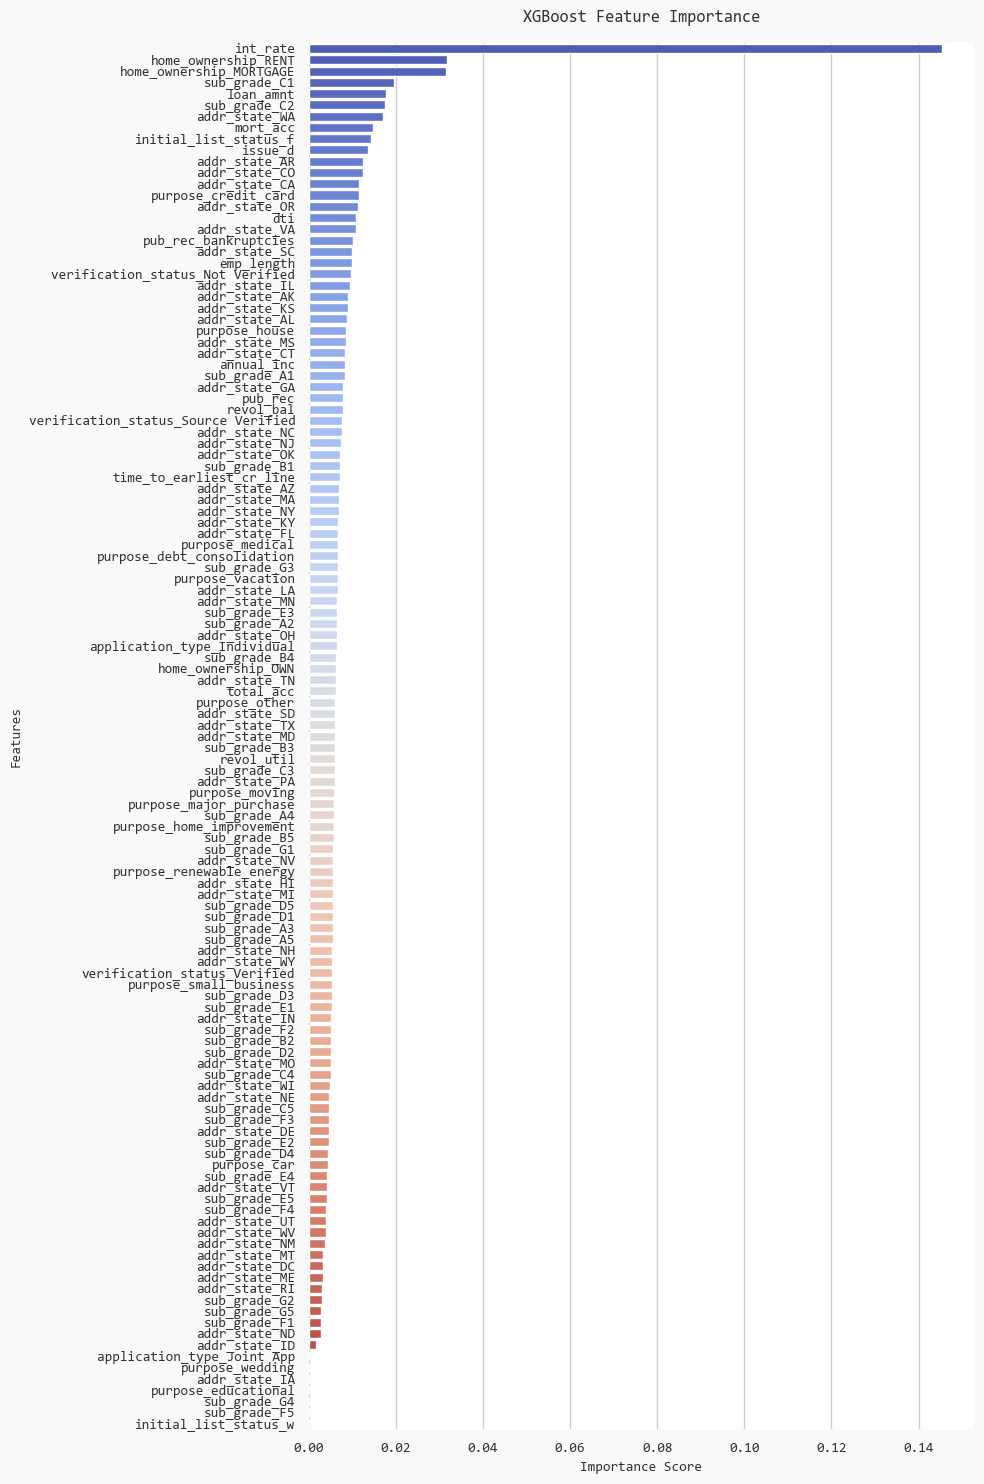


Top 15 Important Features:

                Feature  Importance
               int_rate    0.145454
    home_ownership_RENT    0.031815
home_ownership_MORTGAGE    0.031544
           sub_grade_C1    0.019570
              loan_amnt    0.017789
           sub_grade_C2    0.017608
          addr_state_WA    0.016967
               mort_acc    0.014833
  initial_list_status_f    0.014225
                issue_d    0.013707
          addr_state_AR    0.012523
          addr_state_CO    0.012376
          addr_state_CA    0.011606
    purpose_credit_card    0.011577
          addr_state_OR    0.011405


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create feature importance DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Set style
sns.set(style="whitegrid")

# Initialize plot
plt.figure(figsize=(10, 15))

# Plot with hue assigned to avoid FutureWarning
bar_plot = sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette=sns.color_palette("coolwarm", len(feature_importance_df)),
    hue='Feature',
    dodge=False,
    legend=False
)

# Title and labels with custom font
plt.title('XGBoost Feature Importance', fontfamily="Consolas", fontsize=12, pad=15, color='#333333')
plt.xlabel('Importance Score', fontfamily="Consolas", fontsize=10, color='#333333')
plt.ylabel('Features', fontfamily="Consolas", fontsize=10, color='#333333')

# Customize tick labels
bar_plot.tick_params(axis='x', labelsize=10, labelcolor='#333333')
bar_plot.tick_params(axis='y', labelsize=10, labelcolor='#333333')

for tick_label in bar_plot.get_xticklabels():
    tick_label.set_fontfamily('Consolas')

for tick_label in bar_plot.get_yticklabels():
    tick_label.set_fontfamily('Consolas')

# Clean up
sns.despine(left=True, bottom=True)
plt.gcf().set_facecolor('#f9f9f9')
plt.tight_layout()

plt.show()

# Print Top N Features
top_n = 15
print(f"\nTop {top_n} Important Features:\n")
print(feature_importance_df.head(top_n).to_string(index=False))



###### ✔️ Financial attributes like int_rate, loan_amnt, and mort_acc strongly impact loan risk.

###### ✔️ Borrower profiles such as homeownership status and credit sub-grades matter significantly.

###### ✔️ Geographical location (state) plays a key role, reflecting potential socio-economic patterns.

###### ✔️ Loan purpose & listing attributes offer meaningful signals about borrower intent and market conditions at loan origination.

###### 💡 Model of Choice - XGBoost Classifier

###### ☑️ After evaluating both Random Forest and XGBoost models on classification metrics, XGBoost emerges as the model of choice for the following reasons:

###### ☑️ Higher AUC-ROC (0.8271): Slightly better discriminatory power compared to Random Forest (0.8239), indicating better ability to distinguish between defaulters and non-defaulters.

###### ☑️ Balanced Performance: Despite slightly lower recall for the minority class (0.42 for class 0), it maintains a higher precision (0.59) and overall accuracy (86%), while effectively predicting the majority class (class 1) with recall of 0.95.

###### ☑️ Feature Importance Clarity: XGBoost provides clear insights into influential features like int_rate, home_ownership, and loan_amnt, which can support strategic decision-making and risk assessment.



###### 🎯 Recommendations for Next Steps in Analysis

###### ☑️ Address Class Imbalance
###### ☑️ The model underperforms on minority class (class 0). Apply techniques such as:

###### ☑️ SMOTE or ADASYN (Synthetic Oversampling)

###### ☑️ Class weighting in XGBoost (scale_pos_weight)

###### ☑️ Threshold tuning to improve recall for class 0 (defaulters)